In [13]:
# APO(Absolute Price Oscillator) : 절대 가격 이격도 전략 
  # EMA(Exponential Moving Average) 중 Fast EMA와 Slow EMA간 이격도를 바탕으로 시그널 생성 
  # Final EMA : 최근 가격에 더 반응, Slow EMA 과거 추세에 더 반응하는 Slow EMA 와의 이격정도를 바탕으로 시그널 생성 
  # 과매수 구간 : 기초지수 Long / 인버스지수 Short
  # 과매도 구간 : 인버스지수 Long / 기초지수 Short 
# 0. 기초 prameter 입력 
# 1. APO 시그널 생성하기
# 2. 수익률 생성하기

import pandas as pd
from pandas_datareader import data
from datetime import datetime 
from numpy import inf

In [14]:
#. 0. parameter 입력하기 
start_date = '2007-02-01'
end_date = datetime.today()
num_periods_fast = 5                 # time period for the fast EMA
K_fast = 2 / (num_periods_fast + 1) # smoothing factor for fast EMA
num_periods_slow = 20               # time period for slow EMA
K_slow = 2 / (num_periods_slow + 1) # smoothing factor for slow EMA
TICKER = ['SPY', 'SH']

In [15]:
#. 1. 데이터 불러오기 
df =  data.DataReader(TICKER[0], 'yahoo', start_date, end_date)
close = df['Adj Close']     
df_total = data.DataReader(TICKER, 'yahoo', start_date, end_date)['Adj Close']
df_total.head(10)

Symbols,SPY,SH
Date,,
2007-01-31,107.565475,98.916130
2007-02-01,108.208992,98.293137
2007-02-02,108.358627,98.181297
2007-02-05,108.388580,98.229225
2007-02-06,108.418533,98.261154
2007-02-07,108.657990,98.181297
2007-02-08,108.515785,98.197273
2007-02-09,107.707619,98.948074
2007-02-12,107.341003,99.299538


In [16]:
# 2. APO 시그널 생성하기 
ema_fast = 0
ema_slow = 0
ema_fast_values = [] 
ema_slow_values = [] 
apo_values = [] 
df_result = pd.DataFrame
for close_price in close:
    if (ema_fast == 0): # first observation
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = (close_price - ema_fast) * K_fast + ema_fast
        ema_slow = (close_price - ema_slow) * K_slow + ema_slow
    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)
    apo_values.append(ema_fast - ema_slow)

In [17]:
df_result = df_total.assign(F_EMA=pd.Series(ema_fast_values, index=df.index))
df_result = df_result.assign(S_EMA=pd.Series(ema_slow_values, index=df.index))
df_result = df_result.assign(APO=pd.Series(apo_values, index=df_result.index))
df_result[TICKER[0]]  =  df_result['APO'].apply(lambda x : '1' if x>0 else '0')
df_result[TICKER[1]]  =  df_result['APO'].apply(lambda x : '0' if x>0 else '1')
df_signal = df_result[TICKER]


In [18]:
df_result.head(10)

Symbols,SPY,SH,F_EMA,S_EMA,APO
Date,,,,,
2007-01-31,0,1,107.565475,107.565475,0.000000
2007-02-01,1,0,107.779981,107.626763,0.153218
2007-02-02,1,0,107.972863,107.696464,0.276399
2007-02-05,1,0,108.111436,107.762380,0.349056
2007-02-06,1,0,108.213801,107.824871,0.388931
2007-02-07,1,0,108.361864,107.904215,0.457649
2007-02-08,1,0,108.413171,107.962460,0.450711
2007-02-09,1,0,108.177987,107.938190,0.239797
2007-02-12,1,0,107.898992,107.881315,0.017678


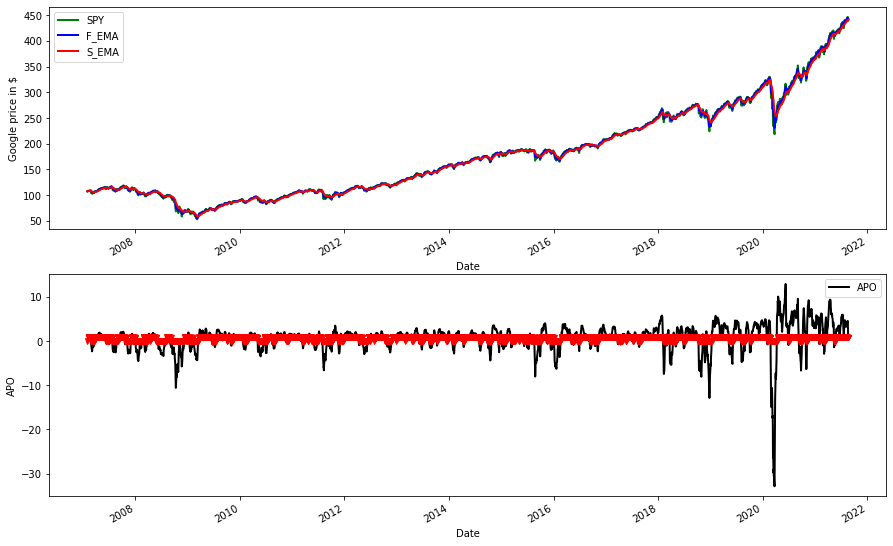

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(211, ylabel='Google price in $')
df_total[TICKER[0]].plot(ax=ax1, color='g', lw=2., legend=True)
df_result['F_EMA'].plot(ax=ax1, color='b', lw=2., legend=True)
df_result['S_EMA'].plot(ax=ax1, color='r', lw=2., legend=True)
ax2 = fig.add_subplot(212, ylabel='APO')
df_result['APO'].plot(ax=ax2, color='black', lw=2., legend=True)
ax2.plot(df_result.index, df_result['APO']>0, 'v', markersize = 5, color = 'r')
plt.show()

In [20]:
# 3. 수익률 생성하기 
df_total = df_total.astype(float)
df_signal = df_signal.astype(float)
dff  = pd.DataFrame((df_signal * df_total))
dff = dff.pct_change().fillna(0)
dff['total'] = dff[TICKER[0]] + dff[TICKER[1]]
dff[dff == inf] = 0

In [21]:
dff

Symbols,SPY,SH,total
Date,,,
2007-01-31,0.000000,0.0,0.000000
2007-02-01,0.000000,-1.0,0.000000
2007-02-02,0.001383,0.0,0.001383
2007-02-05,0.000276,0.0,0.000276
2007-02-06,0.000276,0.0,0.000276
...,...,...,...
2021-08-16,0.002355,0.0,0.002355
2021-08-17,-0.006555,0.0,-0.006555
2021-08-18,-0.010945,0.0,-0.010945


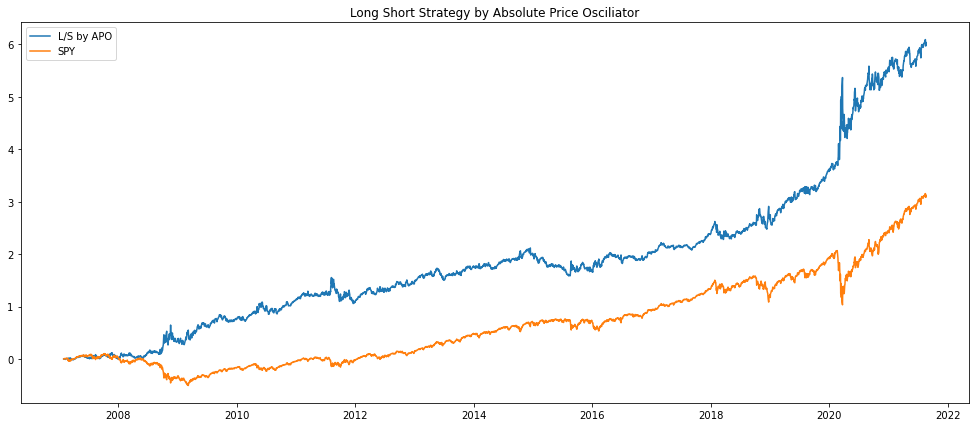

In [22]:
plt.figure(figsize=(17,7))
plt.title('Long Short Strategy by Absolute Price Osciliator')
plt.plot((1 + dff['total']).cumprod() - 1, label = 'L/S by APO')
plt.plot((1+ df_total[TICKER[0]].pct_change().fillna(0)).cumprod() -1 , label = TICKER[0])
plt.legend()
plt.show()